<a href="https://colab.research.google.com/github/Andrew-Bear-cub/emotion_recognition/blob/master/%D0%94%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC_%D0%9C%D0%B0%D0%BA%D0%B0%D1%80%D0%BE%D0%B2_%D1%81_%D0%B0%D0%BA%D1%82%D1%83%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%BC%D0%B8_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8F%D0%BC%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Описание дипломного проекта

##Техническое задание на дипломную работу  

-Дипломная работа — это соревнование на платформе Kaggle. [Ссылка.](https://www.kaggle.com/c/skillbox-computer-vision-project)

-Необходимо написать воспроизводимый код, генерирующий csv-файл с ответами. В нём для каждого изображения с лицом человека должна указываться наиболее вероятная эмоция из представленных. Пример такого файла — на платформе Kaggle (файл *sample_submission.csv*). 

-Вы можете отправить на валидацию не более пяти решений в день.

-Обратите внимание, что на платформе Kaggle существует разбиение отправленного вами файла на public и private части. В задании 50% изображений теста соответствуют публичной части, остальные 50% — приватной. До окончания соревнования результат вашей модели известен только на public-части. Такое разбиение нужно, чтобы модели не переобучались на тесте. 

-Описание данных, формат файла для ответа и метрику качества вы найдёте в самом соревновании на Kaggle. 

##Технические требования 

-Работа требует реализации алгоритма, с помощью которого будет происходить заданная классификация. Приветствуется использование архитектур свёрточных нейронных сетей, разобранных во время теоретических занятий. Время инференса сети на Google Colab не должно превышать 0,33 секунды (3 кадра в секунду).

##Улучшения и дополнения к заданию 

Чтобы выполнить дополнительную просьбу заказчика, попробуйте использовать модель в небольшом прототипе: берите кадры из веб-камеры, прогоняйте их через модель, а в окне камеры выводите результат. 

Для этого сделайте следующее: 

1. Разберитесь с работой камеры на вашем ноутбуке через библиотеку opencv. Примеры работы камеры с opencv смотрите в дополнительных материалах к этому заданию.

2. Возьмите предобученный детектор лица. Используйте примеры из дополнительных материалов или обучите свой детектор. 

3. Оберните вашу модель в Python-класс с методами: 

    a. __init__, в котором будет происходить загрузка весов вашей модели.

    b. predict, который будет принимать на вход предобработанный кадр из веб-камеры и возвращать эмоцию.

4. Сделайте вывод камеры таким, как показано на рисунке ниже. Расположение и цвета элементов остаются на ваше усмотрение. 



# Решение

Для решения задачи распознавания эмоций, Воспользуюсь такими методами, как transfer learning и fine tuning: буду пробовать различные предобученные нейронные сети, и дообучать их последние слои на имеющихся данных, сравнивая результат (Возможно, придется разморозить чуть больше слоев, чем один последний). Для искусственного расширения тестовой выборки будет применена аугментация. Также все изображения будут приведены к единому размеру.

##Необходимые импорты и установки

In [ ]:
# Чтобы не отвлекаться на варнинги
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Придется даунгрейдить некоторые библиотеки чтобы решение работало как надо

!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_vggface
!pip install keras_applications
!pip install livelossplot
!pip install q keras==2.2.4

In [ ]:
# Без этого не построятся модели дальше
!pip install 'h5py==2.10.0' --force-reinstall

In [ ]:
#импортируем нужные для работы библиотеки
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import gdown
from keras_vggface.vggface import VGGFace
import keras as keras
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from livelossplot.tf_keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from livelossplot.tf_keras import PlotLossesCallback
import os 
from pathlib import Path
import glob

TensorFlow 1.x selected.


Using TensorFlow backend.


###Сразу подключим гугл диск

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


###1.[Работа с kaggle в Collab](https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab/50650918#50650918)

In [ ]:
# Необходимые установки
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/SKILLBOX/Machine_learning/Нейросети/Диплом/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

##Для начала посмотрим на имеющиеся данные

In [ ]:
# Скачивание и распаковка
!kaggle competitions download -c skillbox-computer-vision-project
!unzip train.csv.zip
!rm train.csv.zip

  0% 0.00/230k [00:00<?, ?B/s]
100% 230k/230k [00:00<00:00, 33.8MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 90.5MB/s]
Archive:  train.csv.zip
  inflating: train.csv               


Два файла: в одном описание путей до картинок и метки класса, второй - образец ответа, который надо отправить на кэггл. Сами картинки я предварительно скачал на гугл диск и разархивировал, так что поправлю пути в датафрейме чтобы они ссылались на мой гугл-диск

In [ ]:
train_df = pd.read_csv('/content/train.csv')
train_df.sample(5)

,Unnamed: 0,image_path,emotion
32300,32300,./train/sad/2117.jpg,sad
40739,40739,./train/surprise/3647.jpg,surprise
48358,48358,./train/uncertain/4813.jpg,uncertain
30792,30792,./train/neutral/761.jpg,neutral
13035,13035,./train/disgust/795.jpg,disgust


In [ ]:
# Функция которая с помощью конкатенации строк возвращает путь до гугл диска
def apply_drive_path(path):
    return '/content/drive/MyDrive/SKILLBOX/Machine_learning/Нейросети/Диплом' + path[1:]

# Применим написанную выше функцию ко всему столбцу с путями до картинок,
# полученный результат сохраним в отдельный столбец
train_df['drive_path'] = train_df['image_path'].apply(apply_drive_path)

# А также удалим ненужные больше столбцы
train_df = train_df[['drive_path', 'emotion']]
train_df.sample(5)

,drive_path,emotion
20405,/content/drive/MyDrive/SKILLBOX/Machine_learni...,happy
34538,/content/drive/MyDrive/SKILLBOX/Machine_learni...,sad
34215,/content/drive/MyDrive/SKILLBOX/Machine_learni...,sad
32774,/content/drive/MyDrive/SKILLBOX/Machine_learni...,sad
24750,/content/drive/MyDrive/SKILLBOX/Machine_learni...,neutral


##Теперь необходимо разбить наш датасет на тренировочную и валидационную части

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df['drive_path'], 
                                                      train_df['emotion'], 
                                                      test_size=0.33, 
                                                      random_state=42)

In [ ]:
new_train_df = pd.DataFrame(np.vstack((X_train,y_train)).T)
new_train_df.columns=['path', 'emotion']
new_train_df.sample(5)

,path,emotion
31814,/content/drive/MyDrive/SKILLBOX/Machine_learni...,anger
29895,/content/drive/MyDrive/SKILLBOX/Machine_learni...,uncertain
483,/content/drive/MyDrive/SKILLBOX/Machine_learni...,contempt
26860,/content/drive/MyDrive/SKILLBOX/Machine_learni...,happy
16362,/content/drive/MyDrive/SKILLBOX/Machine_learni...,neutral


In [ ]:
new_valid_df = pd.DataFrame(np.vstack((X_valid,y_valid)).T)
new_valid_df.columns=['path', 'emotion']
new_valid_df.sample(5)

,path,emotion
14546,/content/drive/MyDrive/SKILLBOX/Machine_learni...,surprise
11830,/content/drive/MyDrive/SKILLBOX/Machine_learni...,fear
13095,/content/drive/MyDrive/SKILLBOX/Machine_learni...,fear
5894,/content/drive/MyDrive/SKILLBOX/Machine_learni...,happy
10150,/content/drive/MyDrive/SKILLBOX/Machine_learni...,happy


In [ ]:
# Сразу определим размер батча и размер, к которому будем приводить изображения
BATCH_SIZE = 128
IMG_SHAPE  = 224 

Полез в гугл искать готовые решения в области классификации эмоций. Наткнулся на [это](https://github.com/rcmalli/keras-vggface): 

In [ ]:
#Загрузим модели
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace

resnet50_model = VGGFace(model='resnet50',                      #Модель resnet50                          
                         include_top=False,                     #Не берем выходной слой, у нас будет свой
                         input_shape=(IMG_SHAPE, IMG_SHAPE, 3)) #Размер картинки

senet50_model = VGGFace(model='senet50',                        #Модель senet50 
                        include_top=False,                      #Аналогично предыдущей
                        input_shape=(IMG_SHAPE, IMG_SHAPE, 3))


print("Количество слоев в модели resnet50:", len(resnet50_model.layers))
print("Количество слоев в модели senet50:", len(senet50_model.layers))

Количество слоев в модели resnet50: 174
Количество слоев в модели senet50: 286


In [ ]:
# Напишем функцию для обработки картинки и приведению к формату vggface:
# функция на вход принимает тензор размером (1, H, W, 3)  и возвращает картинку,
# с примененным preprocess_input(..., version=2) из keras_vggface. 
# version=2 из документации, т.к. используем модели resnet и senet.
    
def preprocess_input_facenet(image_):
    return utils.preprocess_input(image_, version=2)

In [ ]:
# генератор картинок с аугментацией для тренировочной части

image_gen_aug = ImageDataGenerator(
      preprocessing_function=preprocess_input_facenet,
      rescale=1./255,
      rotation_range=40,        # максимальный угол поворота
      width_shift_range=0.2,    # смещение максимум на 20% ширины по горизонтали
      height_shift_range=0.2,   # смещение максимум на 20% высоты по вертикали
      zoom_range=0.2,           # картинка будет увеличена или уменьшена не более чем на 20% 
      horizontal_flip=True,     # случайное отражение по горизонтали
      fill_mode="nearest",      # чем заполнять пробелы - такие же, как ближайшие пиксели
      )


In [ ]:
# генератор картинок без аугментации для валидационной части
image_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input_facenet)

Тренировочная часть

In [ ]:
train_augmented_data_generator = image_gen_aug.flow_from_dataframe(batch_size=BATCH_SIZE,               #Размер батча
                                                                   dataframe=new_train_df,              #Исходный датафрейм
                                                                   directory=None,                      #Папки нет, поэтому None
                                                                   x_col='path',                        #Столбец в датафрейме откуда берем х
                                                                   y_col='emotion',                     #Столбец в датафрейме откуда берем у
                                                                   shuffle=True,                        #Перемешать картинки после каждого батча
                                                                   target_size=(IMG_SHAPE,IMG_SHAPE),   #Размер картинок, которые подаем на вход модели
                                                                   class_mode='categorical')            #Метки классов - в данном случае категориальные

Found 33530 validated image filenames belonging to 9 classes.


Валидационная часть

In [ ]:
valid_data_generator = image_gen.flow_from_dataframe(batch_size=BATCH_SIZE,                             #Аналогично ячейке выше
                                                               dataframe=new_valid_df,
                                                               directory=None,
                                                               x_col='path',
                                                               y_col='emotion',
                                                               shuffle=False,
                                                               target_size=(IMG_SHAPE,IMG_SHAPE),
                                                               class_mode='categorical')

Found 16516 validated image filenames belonging to 9 classes.


##Сначала опробуем архитектуру Resnet50

In [ ]:
fine_tune_at = 100     #все слои до - заморозим
for layer in resnet50_model.layers[:fine_tune_at]:
    layer.trainable = False

last_layer = resnet50_model.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dense(256, activation='relu', name='fc2')(x)
x = Dense(128, activation='relu', name='fc3')(x)
out = Dense(9, activation='softmax', name='classifier')(x)
first_model = Model(resnet50_model.input, out)

first_model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [ ]:
# Будем сохранять лучшие результаты по ходу обучения модели, для ее последующей 
# загрузки и на случай если коллаб отвалится в процессе обучения.
path = Path("/content/drive/MyDrive/SKILLBOX/Machine_learning/Нейросети/Диплом/")
path.mkdir(exist_ok=True)
checkpoint_filename = "ResNet50_checkpoint_best.hdf5"
checkpoint_path = str(path / checkpoint_filename)
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

# Также будем логировать весь процесс обучения, чтобы видеть, на скольки эпохах 
# уже обучается модель и какие были промежуточные результаты
logdir = Path("/content/drive/MyDrive/SKILLBOX/Machine_learning/Нейросети/Диплом/")

In [ ]:
# Так как коллаб постоянно отваливается, обучу модель одну эпоху а потом буду 
#грузить модель и продолжать обучение
# Первый запуск, запускается единожды.

start = True  #Поменять на True, чтобы код выполнился, False - пропустить ячейку

if start:
    print('Не найден чекпоинт. Начинаем обучение заново.')
    EPOCHS = 1
    history = first_model.fit(train_augmented_data_generator,
                              validation_data=valid_data_generator,
                              epochs=EPOCHS,
                              steps_per_epoch=24,
                              validation_steps=24,
                              callbacks=[checkpoint])

Не найден чекпоинт. Начинаем обучение заново.

Epoch 1/1
24/24 [==============================] - 806s 34s/step - loss: 2.1679 - categorical_accuracy: 0.2217 - val_loss: 1.9887 - val_categorical_accuracy: 0.2878

Epoch 00001: val_categorical_accuracy improved from -inf to 0.28776, saving model to /content/drive/MyDrive/SKILLBOX/Machine_learning/Нейросети/Диплом/ResNet50_checkpoint_best.hdf5


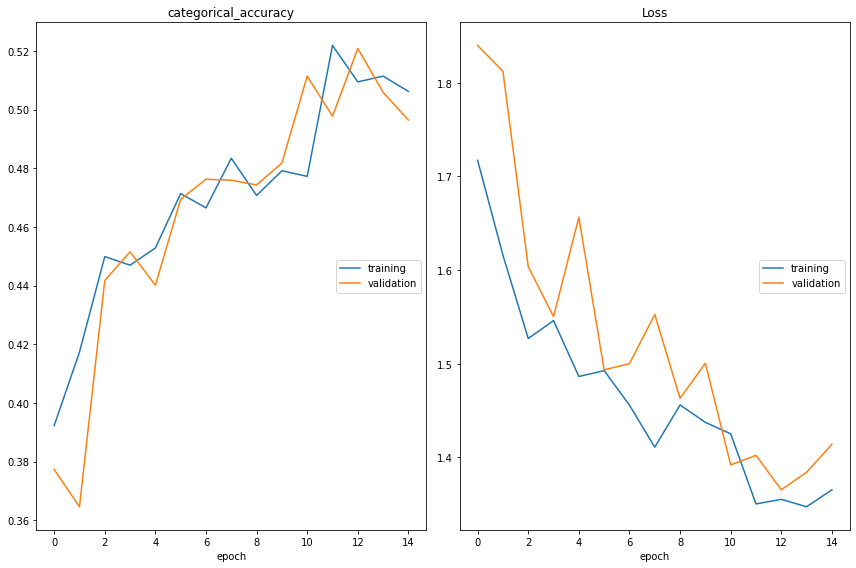

categorical_accuracy
	training         	 (min:    0.392, max:    0.522, cur:    0.506)
	validation       	 (min:    0.365, max:    0.521, cur:    0.496)
Loss
	training         	 (min:    1.347, max:    1.717, cur:    1.365)
	validation       	 (min:    1.365, max:    1.840, cur:    1.414)

Epoch 00015: val_categorical_accuracy did not improve from 0.52083
24/24 [==============================] - 97s 4s/step - loss: 1.3654 - categorical_accuracy: 0.5062 - val_loss: 1.4140 - val_categorical_accuracy: 0.4964


In [ ]:
# Все дальнейшее обучение идет здесь. Пары прогонов достаточно чтобы набрать
# проходной балл, дальше модель уже начинает переобучаться
first_model = tf.keras.models.load_model(checkpoint_path)
print('Найден чекпоинт. Продолжаем обучение.')
EPOCHS = 15
history = first_model.fit(
train_augmented_data_generator,
validation_data=valid_data_generator,
epochs=EPOCHS,
steps_per_epoch=24,
validation_steps=24,
callbacks=[PlotLossesCallback(), 
           CSVLogger(logdir / "ResNet50_history.csv", append=True),
           checkpoint])

In [ ]:
#загрузим обученную модель
model_load = tf.keras.models.load_model(checkpoint_path)

In [ ]:
#Модель возвращает цифровое значение класса, а нам нужно название. Соберем словарь соответствия номера названию из генератора
answers = {}
for (key, value) in valid_data_generator.class_indices.items():
    answers.update({value:key})

answers

{0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise',
 8: 'uncertain'}

In [ ]:
#Функция для создания предсказаний. Поучает на вход картинку, преобразует ее, чтобы подать на вход модели, возвращает предсказанный класс

def for_kaggle(img_path, model):
    #На вход нужна картинка размера 224х224, с гугл диска
    x = image.load_img("/content/drive/MyDrive/SKILLBOX/Machine_learning/Нейросети/Диплом/test_kaggle/"+ img_path, target_size=(IMG_SHAPE, IMG_SHAPE)) 
    #Переводим картинку в массив и разворачиваем его
    x = np.expand_dims(image.img_to_array(x), axis=0)
    #Предобрпбатывамем картинку, веса resnet50 - поэтому вторая версия  
    x = utils.preprocess_input(x, version=2)
    #Возвращаем текстовое описание метки класса, предсказанной с наивысшей вероятностью 
    return answers[np.argmax(model.predict(x))] 

Проверим время инференса


In [ ]:
%%time
for_kaggle("0.jpg", model_load)
for_kaggle("1.jpg", model_load)
for_kaggle("2.jpg", model_load)

CPU times: user 135 ms, sys: 7.14 ms, total: 142 ms
Wall time: 140 ms


По времени инференса пролезли, даже с запасом :)

In [ ]:
#Теперь сформируем файл с предсказаниями, которые нужно будет отправить на кеггл.

#Путь до картинок, для которых необходимо выполнить предсказание эмоций
path_to_predict = '/content/drive/MyDrive/SKILLBOX/Machine_learning/Нейросети/Диплом/test_kaggle/' 
#Пустой датафрейм, куда будем добавлять пути до картинок и соответвтующие им предсказания эмоций
results_frame = pd.DataFrame(columns=['image_path', 'emotion']) 

#Проходимся по всему списку названий картинок в целевой папке
for picture in os.listdir(path_to_predict):
    #Предсказываем эмоцию                                             
    emotion = for_kaggle(picture, model_load)
    #Добавляем пару "путь до карнитнки - эмоция" в датафрейм
    results_frame = results_frame.append({'image_path':picture, 'emotion':emotion}, ignore_index=True)         

results_frame.sample(5)

,image_path,emotion
4853,1766.jpg,fear
1666,4298.jpg,anger
3776,2597.jpg,neutral
2225,300.jpg,fear
2815,3531.jpg,fear


In [ ]:
#выгружаем датасет в csv для отправки на платформу kaggle
results_frame.to_csv('/content/drive/MyDrive/SKILLBOX/Machine_learning/Нейросети/Диплом/resnet50_submission.csv',index=False)

In [ ]:
!cd /content/drive/MyDrive/SKILLBOX/Machine_learning/Нейросети/Диплом/
!cp /content/drive/MyDrive/SKILLBOX/Machine_learning/Нейросети/Диплом/resnet50_submission.csv /content/resnet50_submission.csv

In [ ]:
#Отправляем результат. Будут ошибки кодировки, но все нормально отправляется :)
!cd /content/
!kaggle competitions submit -c skillbox-computer-vision-project -f resnet50_submission.csv -m "Yet another attempt. vggface, resnet50, with augmentation"

100% 78.0k/78.0k [00:01<00:00, 68.5kB/s]
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/kaggle/cli.py", line 64, in main
    print(out, end='')
UnicodeEncodeError: 'latin-1' codec can't encode characters in position 36-44: ordinal not in range(256)


По метрике пролез в зачет :)
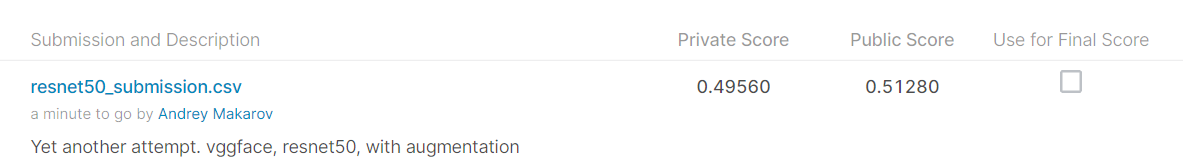


##Теперь попробуем архитектуру seNet оттуда же

In [ ]:
fine_tune_at = 200

# все слои до - заморозим
for layer in senet50_model.layers[:fine_tune_at]:
    layer.trainable = False

last_layer = senet50_model.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dense(256, activation='relu', name='fc3')(x)
out = Dense(9, activation='softmax', name='classifier')(x)
second_model = Model(senet50_model.input, out)

second_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [ ]:
# Будем сохранять лучшие результаты по ходу обучения модели, для ее последующей 
# загрузки и на случай если коллаб отвалится в процессе обучения.
path = Path("/content/drive/MyDrive/SKILLBOX/Machine_learning/Нейросети/Диплом/")
path.mkdir(exist_ok=True)
checkpoint_filename = "SeNet50_checkpoint_best.hdf5"
checkpoint_path = str(path / checkpoint_filename)
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

# Также будем логировать весь процесс обучения, чтобы видеть, на скольки эпохах 
# уже обучается модель и какие были промежуточные результаты
logdir = Path("/content/drive/MyDrive/SKILLBOX/Machine_learning/Нейросети/Диплом/")

In [ ]:
# Так как коллаб постоянно отваливается, обучу модель одну эпоху а потом буду 
#грузить модель и продолжать обучение
# Первый запуск, запускается единожды.

start = True  #Поменять на True, чтобы код выполнился, False - пропустить ячейку

if start:
    print('Не найден чекпоинт. Начинаем обучение заново.')
    EPOCHS = 1
    history = second_model.fit(train_augmented_data_generator,
                              validation_data=valid_data_generator,
                              epochs=EPOCHS,
                              steps_per_epoch=24,
                              validation_steps=24,
                              callbacks=[checkpoint])

Не найден чекпоинт. Начинаем обучение заново.
Epoch 1/1
24/24 [==============================] - 107s 4s/step - loss: 1.9392 - categorical_accuracy: 0.2900 - val_loss: 2.6047 - val_categorical_accuracy: 0.2116

Epoch 00001: val_categorical_accuracy improved from -inf to 0.21159, saving model to /content/drive/MyDrive/SKILLBOX/Machine_learning/Нейросети/Диплом/SeNet50_checkpoint_best.hdf5


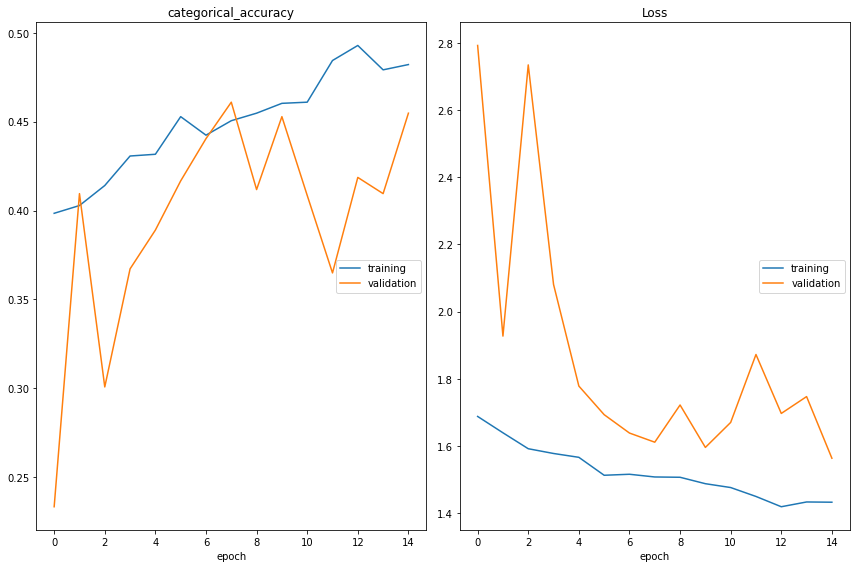

categorical_accuracy
	training         	 (min:    0.398, max:    0.493, cur:    0.482)
	validation       	 (min:    0.233, max:    0.461, cur:    0.455)
Loss
	training         	 (min:    1.419, max:    1.688, cur:    1.432)
	validation       	 (min:    1.563, max:    2.793, cur:    1.563)

Epoch 00015: val_categorical_accuracy did not improve from 0.46094
24/24 [==============================] - 88s 4s/step - loss: 1.4322 - categorical_accuracy: 0.4821 - val_loss: 1.5632 - val_categorical_accuracy: 0.4548


In [ ]:
# Все дальнейшее обучение идет здесь. Пары прогонов достаточно чтобы набрать
# проходной балл, дальше модель уже начинает переобучаться
second_model = tf.keras.models.load_model(checkpoint_path)
print('Найден чекпоинт. Продолжаем обучение.')
EPOCHS = 15
history = second_model.fit(train_augmented_data_generator,
                           validation_data=valid_data_generator,
                           epochs=EPOCHS,
                           steps_per_epoch=24,
                           validation_steps=24,
                           callbacks=[PlotLossesCallback(), 
                                      CSVLogger(logdir / "SeNet50_history.csv", append=True),
                                      checkpoint])

Загрузим модель с чекпоинта

In [ ]:
loaded_senet50_model = tf.keras.models.load_model(checkpoint_path)

Посмотрим на время инференса

In [ ]:
%%time
for_kaggle("0.jpg", loaded_senet50_model)
for_kaggle("1.jpg", loaded_senet50_model)
for_kaggle("2.jpg", loaded_senet50_model)

CPU times: user 184 ms, sys: 6.71 ms, total: 191 ms
Wall time: 183 ms


По времени инференса пролезаем с запасом.

In [ ]:
#Теперь сформируем файл с предсказаниями, которые нужно будет отправить на кеггл.

path_to_predict = '/content/drive/MyDrive/SKILLBOX/Machine_learning/Нейросети/Диплом/test_kaggle/' #Путь до картинок, для которых необходимо выполнить предсказание эмоций
results_frame = pd.DataFrame(columns=['image_path', 'emotion']) #Пустой датафрейм, куда будем добавлять пути до картинок и соответвтующие им предсказания эмоций

for picture in os.listdir(path_to_predict):                                             #Проходимся по всему списку названий картинок в целевой папке
    emotion = for_kaggle(picture, loaded_senet50_model)                                           #Предсказываем эмоцию
    results_frame = results_frame.append({'image_path':picture, 'emotion':emotion}, ignore_index=True)         #Добавляем пару "путь до карнитнки - эмоция" в датафрейм

results_frame.sample(5)

,image_path,emotion
4031,1025.jpg,fear
3846,266.jpg,sad
619,656.jpg,fear
4688,1617.jpg,fear
1903,4510.jpg,neutral


In [ ]:
#выгружаем датасет в csv для отправки на платформу kaggle
results_frame.to_csv('/content/drive/MyDrive/SKILLBOX/Machine_learning/Нейросети/Диплом/senet50_submission.csv',index=False)

In [ ]:
!cd /content/drive/MyDrive/SKILLBOX/Machine_learning/Нейросети/Диплом/
!cp /content/drive/MyDrive/SKILLBOX/Machine_learning/Нейросети/Диплом/senet50_submission.csv /content/senet50_submission.csv

In [ ]:
#Отправляем результат. Будут ошибки кодировки, но все нормально отправляется :)
!cd /content/
!kaggle competitions submit -c skillbox-computer-vision-project -f senet50_submission.csv -m "Yet another attempt. vggface, senet50, with augmentation"

100% 74.6k/74.6k [00:08<00:00, 9.11kB/s]
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/kaggle/cli.py", line 64, in main
    print(out, end='')
UnicodeEncodeError: 'latin-1' codec can't encode characters in position 36-44: ordinal not in range(256)


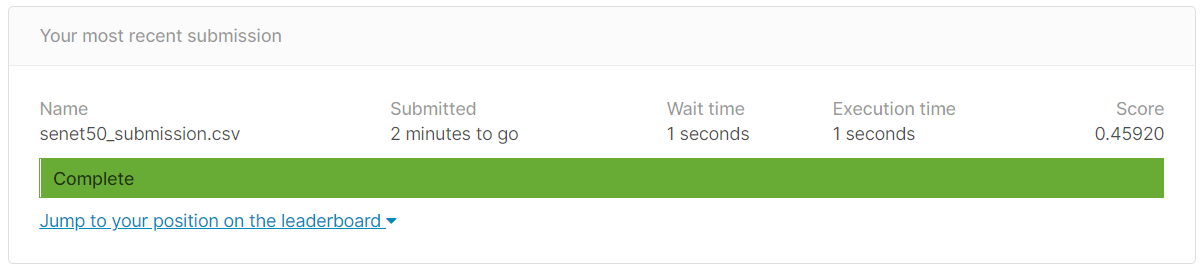

На приватной части лидерборда первая модель показала лучший результат. Будем использовать ее.